Link to dataset: https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy

Scenario 1: State tax board

You are a data scientist in residence at the Iowa State tax board. The Iowa State legislature is considering changes in the liquor tax rates and wants a report of current liquor sales by county and projections for the rest of the year.

Goal for Scenario #1: Your task is as follows:

Calculate the yearly liquor sales for each score using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable.


Use the data from 2015 to make a linear model using as many variables as you find useful to predict the yearly sales of each store. You must use the sales from Jan to March per store as one of your variables.


Use your model for 2015 to estimate total sales for each store in 2016, extrapolating from the sales so far for Jan-March of 2016.


Report your findings, including any projected increase or decrease in total sales (over the entire state) for the tax committee of the Iowa legislature.

Use cross-validation to check how your model predicts to held out data compared to the model metrics on the full dataset.

Challenging Bonus: We did not cover the topics of regularization for linear regression this week, but those feeling bold can try to use and understand regularizing linear regressions. This will require self-guided research/reading and scikit-learn functions that we have not gone over in class! Use cross-validation to tune the regularization parameter that maximizes R^2 on your holdout sets for the Ridge regression and the Lasso Regression. Do the regularized models perform better than the non-regularized model? Which regularized model performs better? What is the Ridge regression doing? What is the Lasso doing.





In [1]:
#load modules and data
# tweak the model 
# subset for max counties 

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

from collections import defaultdict
import datetime
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict

#full data set
df = pd.read_csv('./Iowa_Liquor_sales_sample_10pct.csv')

#sample of dataset
# df = liq.sample(n = 100000)


//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [3]:
df.dtypes

Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null object
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null object
County Number            269878 non-null float64
County                   269878 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null object
State Bottle Retail      270955 non-null object
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null object
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: float64(4), int64(

In [5]:
# check unique values for category name

mygroup = df.groupby(["Category Name", 'Bottle Volume (ml)'])['Category Name']

mygroup.count()

Category Name            Bottle Volume (ml)
100 PROOF VODKA          100                       2
                         200                      42
                         375                      54
                         500                     451
                         600                       9
                         750                    1134
                         1000                    321
                         1750                   1291
AMARETTO - IMPORTED      750                       3
AMERICAN ALCOHOL         750                     573
AMERICAN AMARETTO        600                      18
                         750                     756
                         1000                    436
                         1750                    136
AMERICAN COCKTAILS       200                       6
                         375                     151
                         750                     474
                         800                     260
  

In [6]:
# Checking bottle volumes to see if same liquor will have different sizes

df["Bottle Volume (ml)"].unique()

array([ 750, 1000, 1750,  200,  300,  500,  375, 3000, 2400,  600,  100,
       1200,  800, 4800,  150, 2250, 1500,  400, 3600,   50,  850,  950,
        603, 2550, 6000, 1125, 4500,  900,  250])

In [7]:
df.isnull().sum()

Date                        0
Store Number                0
City                        0
Zip Code                    0
County Number            1077
County                   1077
Category                   68
Category Name             632
Vendor Number               0
Item Number                 0
Item Description            0
Bottle Volume (ml)          0
State Bottle Cost           0
State Bottle Retail         0
Bottles Sold                0
Sale (Dollars)              0
Volume Sold (Liters)        0
Volume Sold (Gallons)       0
dtype: int64

In [8]:
# remove rows where county is null
#  remember set dataframe = to dropna in order to "save" the change
df = df.dropna(subset = ["County"])
df = df.dropna(subset = ["Category"])
#df.dropna(subset=['comments'])

In [9]:
df.isnull().sum()

Date                       0
Store Number               0
City                       0
Zip Code                   0
County Number              0
County                     0
Category                   0
Category Name            552
Vendor Number              0
Item Number                0
Item Description           0
Bottle Volume (ml)         0
State Bottle Cost          0
State Bottle Retail        0
Bottles Sold               0
Sale (Dollars)             0
Volume Sold (Liters)       0
Volume Sold (Gallons)      0
dtype: int64

In [10]:
df["County"].value_counts()

Polk             49098
Linn             23503
Scott            16673
Black Hawk       15076
Johnson          13185
Pottawattamie     9111
Story             8959
Woodbury          8561
Dubuque           7756
Cerro Gordo       6373
Des Moines        4089
Muscatine         3982
Clinton           3574
Wapello           3529
Dickinson         3413
Lee               3321
Webster           3153
Marshall          2995
Jasper            2833
Buena Vista       2747
Dallas            2708
Marion            2603
Warren            2463
Bremer            2242
Boone             2110
Poweshiek         2089
Clay              1917
Carroll           1915
Jones             1874
O'Brien           1720
                 ...  
Greene             677
Wright             672
Shelby             662
Ida                634
Howard             606
Humboldt           588
Adair              585
Grundy             566
Pocahontas         525
Mills              508
Louisa             484
Lucas              476
Chickasaw  

In [11]:
# no dashes in County Column
mask = df.County.str.contains("-")
mask.value_counts()


False    269810
Name: County, dtype: int64

In [12]:
#confirm no dashes
df["County"].unique()

array(['Bremer', 'Scott', 'Black Hawk', 'Story', 'Wright', 'Linn',
       'Wapello', 'Cerro Gordo', 'Polk', 'Benton', 'Mahaska', 'Lee',
       'Johnson', 'Jasper', 'Tama', 'Sioux', 'Dickinson', 'Pottawattamie',
       'Warren', 'Webster', 'Boone', 'Jackson', 'Carroll', 'Hamilton',
       'Woodbury', 'Washington', 'Floyd', 'Delaware', "O'Brien",
       'Buena Vista', 'Grundy', 'Dubuque', 'Adair', 'Crawford', 'Henry',
       'Guthrie', 'Winneshiek', 'Clay', 'Muscatine', 'Taylor', 'Harrison',
       'Hardin', 'Kossuth', 'Dallas', 'Decatur', 'Clinton', 'Butler',
       'Des Moines', 'Calhoun', 'Fayette', 'Jones', 'Hancock', 'Iowa',
       'Howard', 'Appanoose', 'Jefferson', 'Emmet', 'Marshall', 'Page',
       'Cedar', 'Clayton', 'Sac', 'Monona', 'Allamakee', 'Winnebago',
       'Poweshiek', 'Marion', 'Buchanan', 'Franklin', 'Cherokee',
       'Humboldt', 'Greene', 'Keokuk', 'Plymouth', 'Shelby', 'Clarke',
       'Palo Alto', 'Cass', 'Lyon', 'Pocahontas', 'Ida', 'Union',
       'Fremont', '

In [13]:
df.County.describe()
# 99 unique counties in sample
# Polk most common county
#99,624 rows after dropping null values

count     269810
unique        99
top         Polk
freq       49098
Name: County, dtype: object

In [14]:
df.City.unique()

array(['SUMNER', 'DAVENPORT', 'CEDAR FALLS', 'AMES', 'BELMOND',
       'CEDAR RAPIDS', 'OTTUMWA', 'CLEAR LAKE', 'BONDURANT', 'SHELLSBURG',
       'WEST DES MOINES', 'OSKALOOSA', 'WEST POINT', 'CORALVILLE',
       'WATERLOO', 'NEWTON', 'TOLEDO', 'SIOUX CENTER', 'MASON CITY',
       'MILFORD', 'IOWA CITY', 'COUNCIL BLUFFS', 'GRIMES', 'KEOKUK',
       'INDIANOLA', 'FORT DODGE', 'DES MOINES', 'HUXLEY', 'LA PORTE CITY',
       'MARION', 'ANKENY', 'DYSART', 'EAGLE GROVE', 'OGDEN', 'MAQUOKETA',
       'CARROLL', 'WEBSTER CITY', 'SIOUX CITY', 'WASHINGTON',
       'CHARLES CITY', 'MANCHESTER', 'SHELDON', 'ALTOONA', 'STORM LAKE',
       'GRUNDY CENTER', 'SPIRIT LAKE', 'DUBUQUE', 'STUART', 'SCHLESWIG',
       'MOUNT PLEASANT', 'GUTHRIE CENTER', 'FORT ATKINSON', 'SPENCER',
       'MUSCATINE', 'LENOX', 'MISSOURI VALLEY', 'IOWA FALLS', 'ALGONA',
       'WAUKEE', 'LECLAIRE', 'LAMONI', 'CLINTON', 'PARKERSBURG',
       'BURLINGTON', 'DUNLAP', 'ORANGE CITY', 'MANNING', 'LOHRVILLE',
       'JOHNSTON', 'O

In [15]:
df.City.describe()
#380 unique cities in sample
# top city is Des Monies

count         269810
unique           382
top       DES MOINES
freq           23710
Name: City, dtype: object

In [16]:
#convert date column to datetime type

df['Date'] = pd.to_datetime(df['Date'], coerce = True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  app.launch_new_instance()


In [17]:
df.Date.unique()

array(['2015-11-03T16:00:00.000000000-0800',
       '2016-03-01T16:00:00.000000000-0800',
       '2016-02-10T16:00:00.000000000-0800',
       '2016-02-02T16:00:00.000000000-0800',
       '2015-08-17T17:00:00.000000000-0700',
       '2015-04-19T17:00:00.000000000-0700',
       '2015-08-04T17:00:00.000000000-0700',
       '2015-06-24T17:00:00.000000000-0700',
       '2016-01-03T16:00:00.000000000-0800',
       '2015-11-09T16:00:00.000000000-0800',
       '2015-09-27T17:00:00.000000000-0700',
       '2015-10-27T17:00:00.000000000-0700',
       '2015-01-21T16:00:00.000000000-0800',
       '2016-02-28T16:00:00.000000000-0800',
       '2015-06-09T17:00:00.000000000-0700',
       '2016-02-24T16:00:00.000000000-0800',
       '2015-12-28T16:00:00.000000000-0800',
       '2015-12-25T16:00:00.000000000-0800',
       '2015-03-03T16:00:00.000000000-0800',
       '2015-01-15T16:00:00.000000000-0800',
       '2015-01-12T16:00:00.000000000-0800',
       '2015-03-23T17:00:00.000000000-0700',
       '20

In [18]:
df.dtypes

Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                         object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost                object
State Bottle Retail              object
Bottles Sold                      int64
Sale (Dollars)                   object
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

In [19]:
#add year column
df["year"] = df["Date"].dt.year



In [20]:
df["month"] = df["Date"].dt.month

In [21]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),year,month
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38,2015,11
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40,2016,3
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34,2016,2
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77,2016,2
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55,2015,8


In [22]:
df.shape

(269810, 20)

In [23]:
# State Bottle Retail remove $ and convert to float

#remove dollar sign
df["State Bottle Retail"] = df["State Bottle Retail"].replace("\$", "", regex = True) 

#convert to float
df["State Bottle Retail"] = df["State Bottle Retail"].astype(float)

df["State Bottle Cost"] = df["State Bottle Cost"].replace("\$", "", regex = True) 

#convert to float
df["State Bottle Cost"] = df["State Bottle Cost"].astype(float)

df["Sale (Dollars)"] = df["Sale (Dollars)"].replace("\$", "", regex = True) 

#convert to float
df["Sale (Dollars)"] = df["Sale (Dollars)"].astype(float)

In [24]:
df["State Bottle Retail"].unique()

array([  6.75,  20.63,  18.89, ...,  20.64,   9.51,  13.25])

In [25]:
df["State Bottle Retail"].describe()

# mean cost to store 14.81 per bottle 

count    269810.00000
mean         14.67454
std          10.57158
min           1.34000
25%           8.27000
50%          12.27000
75%          17.88000
max         637.50000
Name: State Bottle Retail, dtype: float64

In [26]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),year,month
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38,2015,11
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40,2016,3
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34,2016,2
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77,2016,2
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55,2015,8


In [27]:
df["State Bottle Retail"].median()
# median cost to store per bottle $12.30


12.27

In [28]:
# Sale (Dollars) rremove $ and convert to float

#remove dollar sign
df["Sale (Dollars)"] = df["Sale (Dollars)"].replace("\$", "", regex = True) 

#convert to float
df["Sale (Dollars)"] = df["Sale (Dollars)"].astype(float)

df["State Bottle Cost"] = df["State Bottle Cost"].replace("\$", "", regex = True) 

#convert to float
df["Sale Bottle Cost"] = df["State Bottle Cost"].astype(float)

df["State Bottle Retail"] = df["State Bottle Retail"].replace("\$", "", regex = True) 

#convert to float
df["Sale Bottle Retail"] = df["State Bottle Retail"].astype(float)

In [29]:
df.dtypes

Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                         object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
year                              int64
month                             int64
Sale Bottle Cost                float64
Sale Bottle Retail              float64
dtype: object

In [30]:
#df["Sale (Dollars)"].unique

In [31]:
df["Sale (Dollars)"].describe()

# mean revenue per transaction is $131.76
# do not use mean to desribe average revenue

count    269810.000000
mean        128.965269
std         383.663915
min           1.340000
25%          30.450000
50%          70.560000
75%         135.000000
max       36392.400000
Name: Sale (Dollars), dtype: float64

In [32]:
df["Sale (Dollars)"].median()

# median revenue per transaction is $70.56

70.56

In [33]:
df["Bottles Sold"].unique()

array([  12,    2,   24,    6,    3,    4,    1,   48,   18,    5,    9,
         60,   36,    7,   10,    8,  240,  192,  132,   30,  384,   66,
        120,   96,   42,  336,  180,   13,   44,   72,   54,  144,  300,
         90, 1200,   84,  660,  126,   15,  600,  168,  288,   11,  228,
         57,  402,  480,   78,  108,   20,  360,  150,   16,  408,  528,
        174,  960,  156,   14,  582,  456,  330,  474,  720,  840,   19,
        552,  570,  204, 2508,  264,  594,  768,  576,  354, 1320,  210,
        780,  312,   25,   33,  900, 1080,   88,  444,  420,  216,  372,
         40,  270,  432,  102,  324,  138,  252,  540,  564,  276,  984,
       1164,   80,  450,  504, 2400,   50,  114,   34,   21,  624,   75,
        157,  162,  708,  282,   17,  198, 1800,  247,  588,  186,  390,
        516,   28,  672,  396, 1050, 1116,   97,   81, 1128,  438,  492,
        378,  816,   39,   37,  615])

In [34]:
df["Bottles Sold"].describe()
# mean bottles sold per transaction is approximately 10
# do not use mean for analysis

count    269810.000000
mean          9.874334
std          24.064832
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max        2508.000000
Name: Bottles Sold, dtype: float64

In [35]:
df["Bottles Sold"].median()
# median bottles sold per transaction is 6

6.0

In [251]:
#correlation matrix
df.corr()

,Store Number,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),year,month,Sale Bottle Cost,Sale Bottle Retail
Store Number,1.000000,0.007572,-0.012266,-0.004653,-0.026552,-0.062789,-0.071392,-0.071528,0.014817,-0.017620,-0.017297,-0.017286,0.020334,0.004926,-0.071392,-0.071528
County Number,0.007572,1.000000,-0.006336,0.001681,0.006824,-0.027823,0.012149,0.012075,0.018952,0.019854,0.010194,0.010203,0.003084,-0.001191,0.012149,0.012075
Category,-0.012266,-0.006336,1.000000,0.091787,0.116240,-0.009339,-0.013471,-0.013658,-0.000155,0.006447,-0.004296,-0.004287,-0.016347,0.051328,-0.013471,-0.013658
Vendor Number,-0.004653,0.001681,0.091787,1.000000,0.136058,0.024799,0.003689,0.003297,-0.002258,-0.012324,-0.007457,-0.007453,0.006593,-0.001689,0.003689,0.003297
Item Number,-0.026552,0.006824,0.116240,0.136058,1.000000,-0.057292,0.097714,0.097446,-0.004690,0.003097,-0.009467,-0.009457,0.001241,-0.002275,0.097714,0.097446
Bottle Volume (ml),-0.062789,-0.027823,-0.009339,0.024799,-0.057292,1.000000,0.312128,0.313108,-0.012078,0.082576,0.156317,0.156149,-0.002616,-0.002401,0.312128,0.313108
State Bottle Cost,-0.071392,0.012149,-0.013471,0.003689,0.097714,0.312128,1.000000,0.999960,-0.062789,0.135784,0.009275,0.009244,0.000945,0.011893,1.000000,0.999960
State Bottle Retail,-0.071528,0.012075,-0.013658,0.003297,0.097446,0.313108,0.999960,1.000000,-0.062641,0.135967,0.009714,0.009683,0.000581,0.012035,0.999960,1.000000
Bottles Sold,0.014817,0.018952,-0.000155,-0.002258,-0.004690,-0.012078,-0.062789,-0.062641,1.000000,0.826022,0.883978,0.884008,-0.006686,0.011301,-0.062789,-0.062641
Sale (Dollars),-0.017620,0.019854,0.006447,-0.012324,0.003097,0.082576,0.135784,0.135967,0.826022,1.000000,0.846509,0.846520,-0.008290,0.014584,0.135784,0.135967


In [36]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),year,month,Sale Bottle Cost,Sale Bottle Retail
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,4.50,6.75,12,81.00,9.0,2.38,2015,11,4.50,6.75
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,...,13.75,20.63,2,41.26,1.5,0.40,2016,3,13.75,20.63
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,...,12.59,18.89,24,453.36,24.0,6.34,2016,2,12.59,18.89
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,...,9.50,14.25,6,85.50,10.5,2.77,2016,2,9.50,14.25
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,7.20,10.80,12,129.60,21.0,5.55,2015,8,7.20,10.80


Calculate the yearly liquor sales for each store using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable.

In [37]:
# filter for 2015
mask2015 = df["year"] == 2015

df15 = df[mask2015]

df_1 = df.copy()



In [38]:
df_1.isnull().sum()

Date                       0
Store Number               0
City                       0
Zip Code                   0
County Number              0
County                     0
Category                   0
Category Name            552
Vendor Number              0
Item Number                0
Item Description           0
Bottle Volume (ml)         0
State Bottle Cost          0
State Bottle Retail        0
Bottles Sold               0
Sale (Dollars)             0
Volume Sold (Liters)       0
Volume Sold (Gallons)      0
year                       0
month                      0
Sale Bottle Cost           0
Sale Bottle Retail         0
dtype: int64

In [39]:
df_1.dtypes


Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                         object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
year                              int64
month                             int64
Sale Bottle Cost                float64
Sale Bottle Retail              float64
dtype: object

In [40]:
df = df.dropna(subset = ["Category"])

In [41]:
df15.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),year,month,Sale Bottle Cost,Sale Bottle Retail
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,4.50,6.75,12,81.00,9.00,2.38,2015,11,4.50,6.75
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,7.20,10.80,12,129.60,21.00,5.55,2015,8,7.20,10.80
5,2015-04-20,2569,CEDAR RAPIDS,52402,57.0,Linn,1041100.0,AMERICAN DRY GINS,205,31473,...,13.32,19.98,6,119.88,10.50,2.77,2015,4,13.32,19.98
6,2015-08-05,2596,OTTUMWA,52501,90.0,Wapello,1051010.0,AMERICAN GRAPE BRANDIES,85,52806,...,6.66,9.99,3,29.97,2.25,0.59,2015,8,6.66,9.99
7,2015-06-25,3456,CLEAR LAKE,50428,17.0,Cerro Gordo,1012100.0,CANADIAN WHISKIES,65,10628,...,15.75,23.63,2,47.26,3.50,0.92,2015,6,15.75,23.63


In [42]:
df15["year"].unique()

array([2015])

In [43]:
# group by and sum
df2015 = df15.groupby(["year","County","City","Store Number"])["Sale (Dollars)"].sum()


#syntax:
#dataframe.groupby(["column","column"])["column you want aggregrate to act on"].aggregrate function()
#data.groupby(['col1', 'col2'])['col3'].mean()

In [44]:
# convert to dataframe

df2015_2 = df2015.to_frame()

In [45]:
df2015_2.head()

Sale (Dollars)
year County City       Store Number                
2015 Adair  ADAIR      4417                 3482.94
                       4753                 1475.10
            FONTANELLE 4620                 6495.09
            GREENFIELD 3969                 1393.94
                       4317                 9983.13

In [46]:
df2015_2.columns

Index([u'Sale (Dollars)'], dtype='object')

In [47]:
df2015_2 = df2015.reset_index()

In [48]:
df2015_2.head()

,year,County,City,Store Number,Sale (Dollars)
0,2015,Adair,ADAIR,4417,3482.94
1,2015,Adair,ADAIR,4753,1475.10
2,2015,Adair,FONTANELLE,4620,6495.09
3,2015,Adair,GREENFIELD,3969,1393.94
4,2015,Adair,GREENFIELD,4317,9983.13


In [49]:
df2015_2["Store Number"].value_counts()

3782    2
4092    1
2593    1
2585    1
4634    1
4635    1
2588    1
4637    1
2590    1
2591    1
2592    1
4642    1
4631    1
2595    1
4644    1
2597    1
4647    1
4648    1
2601    1
2602    1
4651    1
2584    1
2582    1
4653    1
4629    1
2564    1
4613    1
2566    1
2652    1
2568    1
       ..
5149    1
5150    1
5151    1
5152    1
5153    1
5154    1
5155    1
5156    1
5139    1
5137    1
4630    1
5136    1
5117    1
5118    1
5119    1
2609    1
5121    1
5123    1
5124    1
5125    1
5126    1
4728    1
5128    1
5129    1
5131    1
5132    1
5133    1
5134    1
5135    1
4097    1
Name: Store Number, dtype: int64

In [50]:
df2015.columns

AttributeError: 'Series' object has no attribute 'columns'

In [51]:
df2015["Store Number"].count()
# of stores in the sample

KeyError: 'Store Number'

In [ ]:
df2015["County"].count()

In [53]:
#subest store number 

sn = list(df2015["Store Number"].values)
sd = list(df2015["Sale (Dollars)"].values)

# Sales Revenue for each store in sample for 2015
# include in final presentation
store_sales = dict(zip(sn,sd)) 


KeyError: 'Store Number'

In [52]:

df_1 = df.copy()

In [54]:
xtrain_2015 = df_2015[cols]
ytrain_2015 = df_2015["Sale (Dollars)"]
xtest_2016 = df_2016[cols]
ytest_2016 = df_2016["Sale (Dollars)"]
lr.fit(xtrain_2015,ytrain_2015)

NameError: name 'df_2015' is not defined

In [56]:
pred = lr.predict(xtest_2016)

NameError: name 'xtest_2016' is not defined

In [57]:
lr.score(xtest_2016,ytest_2016)

NameError: name 'xtest_2016' is not defined

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
lr = LinearRegression()

df_2015= df_1[df_1['year'] == 2015]
df_2016 = df_1[df_1['year'] == 2016]

cols = ['County Number','Store Number','Category','State Bottle Cost','State Bottle Retail','Bottles Sold','Volume Sold (Liters)','year','month']
x= df_2015[cols]
y = df_2015['Sale (Dollars)']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = .33)


lr.fit(x_train,y_train)

print y_train[0:10]

# print df_1.columns
# fit a OLS model
#X = sm.add_constant(x)
#est = sm.OLS(y, X.astype(float)).fit()

#print est.summary()

75856      94.20
209607     36.00
4870       43.60
22247     148.56
101994     11.43
169492     98.94
249679     27.00
110173    816.48
18106      27.63
109204    226.68
Name: Sale (Dollars), dtype: float64


In [221]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
lr = LinearRegression(normalize=True)

df_2015= df_1[df_1['year'] == 2015]
df_2015_train = df_2015[df_2015['month'] < 4]

df_2015_test = df_2015[df_2015['month'] >= 4]
df_2016 = df_1[df_1['year'] == 2016]


cols = ['Store Number','County Number','Category','Vendor Number','Item Number','State Bottle Cost','State Bottle Retail','Bottles Sold','Volume Sold (Liters)','Volume Sold (Gallons)','year','month']
x_train = df_2015_train[cols]
y_train = df_2015_train['Sale (Dollars)']
x_test = df_2015_test[cols]
y_test = df_2015_test['Sale (Dollars)']
#x= df_2015[cols]
#y = df_2015['Sale (Dollars)']
#x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = .33)


lr.fit(x_train,y_train)

#print y_train[0:10]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [222]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(df_2015['Sale (Dollars)'], n_folds =5)

In [223]:
x_test = df_2015_test[cols]
y_test = df_2015_test['Sale (Dollars)']
prediction = lr.predict(x_test)

In [224]:
lr.score(x_test,y_test)

0.75285624178841082

In [225]:
x = df_2016[cols]
y = df_2016['Sale (Dollars)']

In [226]:
pred = lr.predict(x)
#print pred

y = np.array(y)
print y
#type(pred)
y.shape


[  41.26  453.36   85.5  ...,   51.3    21.44   14.26]


(51400,)

In [227]:
lr.score(x,y)

0.78862347533871546

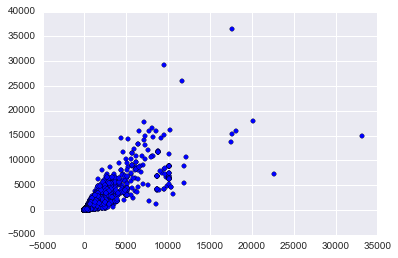

In [228]:
plt.scatter(prediction,y_test)

In [229]:
lr.score(x_test,y_test)



0.75285624178841082

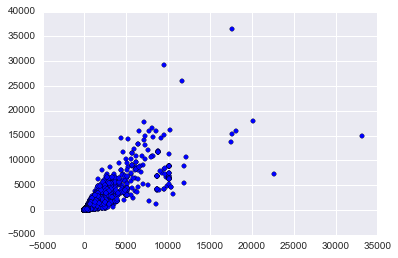

In [230]:
plt.scatter(prediction,y_test)


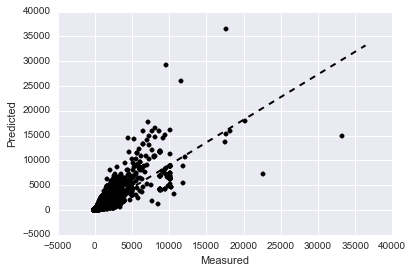

In [248]:
clf = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), normalize=True, cv=5)

model2 = clf.fit(x_train,y_train)
predictions2 = clf.predict(x_test)

fig, ax = plt.subplots()
ax.plot([y_test.min(), y_test.max()], [predictions2.min(), predictions2.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.scatter(predictions2, y_test,  color='black')

In [232]:
model2.score(x_test,y_test)

0.75287014629215609

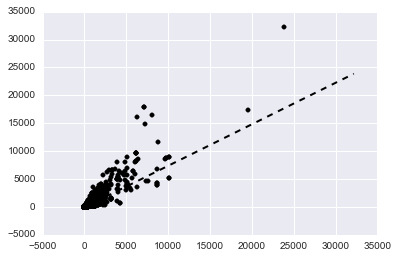

In [249]:
clf = linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), normalize=True, cv=5)

model3 = clf.fit(x_train,y_train)
predictions3 = clf.predict(x)
fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [predictions3.min(), predictions3.max()], 'k--', lw=2)

plt.scatter(predictions3, y,  color='black')

In [234]:
print "Linear model:", lr.coef_
print "Ridge model:", model2.coef_

Linear model: [ -2.25465231e-03   3.41320329e-02   1.28392645e-04  -2.02233723e-02
  -7.55381304e-05   4.61427795e+01  -2.50881649e+01   8.49025580e+00
   1.97522413e+01  -5.67614453e+01   0.00000000e+00   1.00921890e+00]
Ridge model: [ -2.25487547e-03   3.40394947e-02   1.28440146e-04  -2.01861088e-02
  -7.55313046e-05   4.35473031e+01  -2.33567633e+01   8.48822199e+00
   5.02134690e+00  -9.94677575e-01   0.00000000e+00   1.00533321e+00]


In [235]:
compare = zip(lr.coef_, model2.coef_)
print compare

[(-0.0022546523134695908, -0.0022548754688175182), (0.03413203289481713, 0.034039494654384848), (0.00012839264475730304, 0.0001284401456871707), (-0.020223372310926233, -0.020186108759973682), (-7.5538130424150139e-05, -7.55313045946023e-05), (46.142779531838144, 43.547303148002975), (-25.088164887044112, -23.356763313619194), (8.4902558021560619, 8.4882219881163099), (19.752241322416726, 5.0213469022445159), (-56.761445286514331, -0.99467757467079687), (0.0, 0.0), (1.0092188998125995, 1.0053332131340751)]


In [236]:
for i in compare:
    print "Linear Coeff: ", i[0], " Ridge Coeff: ", i[1], " Difference: ", i[1]-i[0]

Linear Coeff:  -0.00225465231347  Ridge Coeff:  -0.00225487546882  Difference:  -2.23155347927e-07
Linear Coeff:  0.0341320328948  Ridge Coeff:  0.0340394946544  Difference:  -9.25382404323e-05
Linear Coeff:  0.000128392644757  Ridge Coeff:  0.000128440145687  Difference:  4.75009298677e-08
Linear Coeff:  -0.0202233723109  Ridge Coeff:  -0.02018610876  Difference:  3.72635509526e-05
Linear Coeff:  -7.55381304242e-05  Ridge Coeff:  -7.55313045946e-05  Difference:  6.82582954784e-09
Linear Coeff:  46.1427795318  Ridge Coeff:  43.547303148  Difference:  -2.59547638384
Linear Coeff:  -25.088164887  Ridge Coeff:  -23.3567633136  Difference:  1.73140157342
Linear Coeff:  8.49025580216  Ridge Coeff:  8.48822198812  Difference:  -0.00203381403975
Linear Coeff:  19.7522413224  Ridge Coeff:  5.02134690224  Difference:  -14.7308944202
Linear Coeff:  -56.7614452865  Ridge Coeff:  -0.994677574671  Difference:  55.7667677118
Linear Coeff:  0.0  Ridge Coeff:  0.0  Difference:  0.0
Linear Coeff:  1.00

In [241]:
import plotly.plotly as py
from plotly.graph_objs import *

colorscale = [[0, '#3D9970'], [1, '#001f3f']]

data = [
    go.Heatmap(
        z=[lr.coef_, model2.coef_,(model2.coef_-lr.coef_)],
        y=['Linear', 'Ridge', 'Difference'],
        x=cols,
        colorscale=colorscale, 
        showscale=False
    )
]

        
py.iplot(data, filename='basic-heatmap')
